# DistilBERT for topic classification
First, load the necessary libraries:

In [49]:
%pip install pyarrow fastparquet seaborn


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [50]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import json
from collections import Counter
import random
import matplotlib.pyplot as plt

### Preparation and balancing of the dataset

In [51]:
def load_pickle_data(file_path):
    return pd.read_pickle(file_path)

def split_data(data):
    train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
    return train_df, test_df

try:
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = '/content/drive/MyDrive/DataScienceLab/GenericMixOfTopic.parquet'
    pickle_data_path = '/content/drive/MyDrive/DataScienceLab/main_dataset_correctedSingleTopics.pkl'
except:
    data_path = 'dsl_project/GenericMixOfTopic.parquet'
    pickle_data_path = 'dsl_project/main_dataset_correctedSingleTopics.pkl'
    test_set_path = 'dsl_project/test_set.pkl'

In [52]:
data = load_pickle_data(test_set_path)

# Set the desired number of entries
N = 5000

# Step 2: Randomly downsample the dataset to have less random samples
data = data.sample(n=N//2, random_state=42)

def get_label_columns(df):
    topics = set()
    for item in df['topics_with_percentages']:
        topics.update(item.keys())
    topics = list(topics)
    return topics

label_columns = get_label_columns(data)

In [53]:
# get rows where topic is different from 'Mixed'
data

,id,title,topic,topics_with_percentages,text,Academic_disciplines,Business,Communication,Concepts,Culture,...,People,Philosophy,Politics,Religion,Science,Society,Sports,Technology,Time,Universe
46430,367399,Safrole,Mixed,"{'Science': 0.25, 'Society': 0.25, 'Health': 0...",chembox | Verifiedfields changed | Watchedfi...,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
122070,1904123,Gerard of Csanád,Mixed,"{'People': 0.77, 'Religion': 0.07, 'Society': ...",Gerard or Gerard Sagredo ( ; ; ; 23 April 97...,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
142100,61768376,Pleurotomella protocostulata,Mixed,"{'Life': 0.42, 'Nature': 0.25, 'Health': 0.17,...",'Pleurotomella protocostulata' is an extinct...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11359,34824285,2012 WGC-Accenture Match Play Championship,Mixed,"{'Sports': 0.77, 'Entertainment': 0.1, 'Cultur...",The 2012 WGC-Accenture Match Play Championsh...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
119262,366499,Magnum Research,Mixed,"{'Geography': 0.4, 'Business': 0.27, 'Engineer...",Magnum Research Inc. (MRI) was an American p...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82615,47043477,Chief of Civil Administration,Mixed,"{'Military': 0.67, 'Government': 0.33, 'Academ...",Chief of Civil Administration ( ) was an off...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120054,18698055,Sovereignty Party,Mixed,"{'Politics': 0.5, 'Time': 0.33, 'History': 0.1...",The Sovereignty Party ( ) was a political pa...,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
77589,254154,Argument from free will,Mixed,"{'Philosophy': 0.67, 'History': 0.17, 'Time': ...","The argument from free will, also called the...",0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
130871,373299,Language of mathematics,Mixed,"{'Mathematics': 0.5, 'Language': 0.5, 'Academi...",The language of mathematics or mathematical ...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
data.iloc[0]

id                                                                    367399
title                                                                Safrole
topic                                                                  Mixed
topics_with_percentages    {'Science': 0.25, 'Society': 0.25, 'Health': 0...
text                         chembox | Verifiedfields changed | Watchedfi...
Academic_disciplines                                                       0
Business                                                                   0
Communication                                                              0
Concepts                                                                   0
Culture                                                                    0
Economy                                                                    0
Education                                                                  0
Energy                                                                     0

In [55]:
len(label_columns)

39

### LLM Setup

In [56]:
%pip install requests
%pip install backoff
%pip install groq


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [57]:
import os
import backoff
import time
import requests
from groq import Groq
import random


class LLM:

    def __init__(self, api_key=None):
        
        self.api_key = api_key
        self.client = Groq(api_key="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")
        model_list = self.client.models.list().to_dict()["data"]

        # remove from momdel_list the entry "whisper-large-v3"
        model_list = [model for model in model_list if model["id"] != "whisper-large-v3"]

        self.models = [
            model["id"] for model in model_list
        ]
        # self.model = "llama3-70b-8192"

    def send_chat_message(self, content) -> str:
        time.sleep(1)
        
        try:
            
            if len(content) > 2 * 8000:
                print("Content too long, skipping...")
                return -1, None
                # updated_model = "mixtral-8x7b-32768"
                # print("Content too long, switching to Mixtral...")

            random_model = random.choice(self.models)

            chat_completion = self.client.chat.completions.create(
                model= random_model,
                messages=[
                    {
                        "role": "user",
                        "content": content,
                    }
                ],
            )

            updated_model = None

            response = chat_completion.choices[0].message.content
            # print(response)
            return response, random_model
        except Exception as e:
            # self.logger.log_error(f"Error sending chat message: {e}")
            print(f"Error sending chat message: {e}")

            # Applying exponential backoff with a maximum of 5 retries
            @backoff.on_exception(
                backoff.expo, requests.exceptions.HTTPError, max_tries=10
            )
            def retry_send_chat_message():
                # self.logger.log_info(f"Rate limit exceeded. Waiting...")
                print("Rate limit exceeded. Waiting...")
                return self.send_chat_message(content)
            return retry_send_chat_message()

In [58]:
llm = LLM()

labels = ','.join(label_columns)

In [59]:
def classify_article(article, labels):
    # classification_prompt = f"""
    #   You are a highly advanced language model specialized in text classification.
    #   Your task is to classify the following article into relevant categories from a predefined list of 39 possible labels.

    #   The labels are: {labels}

    #   When classifying, follow these guidelines:
    #   1. Carefully read the entire article.
    #   2. Assign all relevant labels from the list to the article.
    #   3. If a label is not applicable, do not include it.
    #   4. Ensure the classifications are precise and based on the content.

    #   Here is an example of the format you should follow:

    #   Article:
    #   '''
    #   Julius Julskötare' (&quot;Julius Christmas Handler&quot;) or 'Kalenderhuset' (&quot;The Calendar House&quot;)
    #   was the Sveriges Television's Christmas calendar in 1978. When aired at SVT1|TV1 in 1978, it had no official name,
    #   other than that of Christmas calendar. Plot The main character, played by Björn Skifs , guides the viewers taking
    #   a look at some fictional companies. Video On 23 October 2013, the series was released to DVD . References External
    #   links
    #   '''

    #   Labels: \"Entertainment\", \"Culture\", \"Mass_media\".

    #   Now, classify the following article:

    #   Article:
    #   '''
    #   {article}
    #   '''

    #   Please answer only with at 3 most probable labels separated by commas and without any other text.

    #   Labels:
    #   """
    classification_prompt = f"""
      You are an expert text classifier. Your task is to assign the most relevant labels to the given article from a predefined list of 39 categories.

      Labels: {labels}

      Guidelines:
      1. Thoroughly analyze the article's content.
      2. Assign up to 3 most relevant labels from the provided list.
      3. You may assign fewer than 3 labels if that better represents the content.
      4. Focus on the main themes and topics of the article.
      5. Avoid assigning labels that are only tangentially related.

      Example:
      Article: '''
      Julius Julskötare' ("Julius Christmas Handler") or 'Kalenderhuset' ("The Calendar House") was the Sveriges Television's Christmas calendar in 1978. 
      When aired at SVT1|TV1 in 1978, it had no official name, other than that of Christmas calendar. 
      Plot The main character, played by Björn Skifs, guides the viewers taking a look at some fictional companies. 
      Video On 23 October 2013, the series was released to DVD. References External links
      '''
      Labels: Entertainment, Culture, Mass_media

      Now, classify the following article:

      Article:
      '''
      {article}
      '''

      Provide only the most relevant labels (maximum 3) separated by commas, without any additional text or explanation.

      Labels:
      """

    classification, model = llm.send_chat_message(classification_prompt)
    return classification, len(classification_prompt), model

In [60]:
# classify_article(test_df.iloc[0].text, labels)

In [61]:
small_test_df = None

In [62]:
import pandas as pd

# small_test_df = pd.read_pickle('dsl_project/predictions_with_models2024-07-12.pkl')

In [63]:
from tqdm import tqdm

if small_test_df is None or small_test_df.empty:
    small_test_df = data

    # Initialize the 'prediction' column with None or any default value
    small_test_df['prediction'] = None
    small_test_df['model'] = None


In [64]:
for idx in tqdm(small_test_df.index):
  if small_test_df.at[idx, 'prediction']:
    tqdm.write(f"[SKIP] Article {idx+1} already classified")
    continue
  
  article = small_test_df.loc[idx, 'text']
  prediction, len_prediction, model = classify_article(article, labels)
  
  # tqdm.write(f"Article {idx+1}")
  # tqdm.write(f"Prompt length: {len_prediction}")
  # tqdm.write(f"Prediction: {prediction}")

  # Update the 'prediction' column for the current row
  small_test_df.at[idx, 'prediction'] = prediction
  small_test_df.at[idx, 'model'] = model

  0%|          | 2/2500 [00:02<51:51,  1.25s/it]  

Content too long, skipping...


  1%|          | 18/2500 [00:25<56:37,  1.37s/it]  

Content too long, skipping...


  1%|          | 27/2500 [00:41<1:22:06,  1.99s/it]

Content too long, skipping...


  2%|▏         | 59/2500 [01:53<1:08:33,  1.69s/it]

Content too long, skipping...


  3%|▎         | 73/2500 [02:30<1:06:39,  1.65s/it]

Content too long, skipping...


  3%|▎         | 81/2500 [02:40<48:23,  1.20s/it]  

Content too long, skipping...


  4%|▍         | 98/2500 [03:21<1:08:45,  1.72s/it]

Content too long, skipping...


  5%|▍         | 114/2500 [04:16<1:24:27,  2.12s/it]

Content too long, skipping...


  5%|▍         | 115/2500 [04:17<1:11:01,  1.79s/it]

Content too long, skipping...


  5%|▌         | 129/2500 [04:39<53:36,  1.36s/it]  

Content too long, skipping...


  6%|▌         | 143/2500 [05:18<3:34:20,  5.46s/it]

Content too long, skipping...


  7%|▋         | 171/2500 [06:25<2:32:47,  3.94s/it]

Content too long, skipping...


  8%|▊         | 196/2500 [07:57<59:29,  1.55s/it]  

Content too long, skipping...


  8%|▊         | 208/2500 [08:26<1:17:38,  2.03s/it]

Content too long, skipping...


  9%|▊         | 214/2500 [09:24<3:54:33,  6.16s/it]

Content too long, skipping...


  9%|▉         | 225/2500 [10:51<7:46:53, 12.31s/it] 

Content too long, skipping...


  9%|▉         | 230/2500 [10:57<1:55:23,  3.05s/it]

Content too long, skipping...


 11%|█         | 265/2500 [13:14<1:09:10,  1.86s/it]

Content too long, skipping...


 11%|█▏        | 283/2500 [14:06<54:53,  1.49s/it]  

Content too long, skipping...


 12%|█▏        | 288/2500 [14:13<48:07,  1.31s/it]

In [ ]:
small_test_df

,id,title,topic,topics_with_percentages,text,Academic_disciplines,Business,Communication,Concepts,Culture,...,Politics,Religion,Science,Society,Sports,Technology,Time,Universe,prediction,model
46430,367399,Safrole,Mixed,"{'Science': 0.25, 'Society': 0.25, 'Health': 0...",chembox | Verifiedfields changed | Watchedfi...,0,0,0,0,0,...,0,0,1,1,0,0,0,0,"Science, Chemistry",llama3-8b-8192
142100,61768376,Pleurotomella protocostulata,Mixed,"{'Life': 0.42, 'Nature': 0.25, 'Health': 0.17,...",'Pleurotomella protocostulata' is an extinct...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"Nature, Science, Universe",mixtral-8x7b-32768
11359,34824285,2012 WGC-Accenture Match Play Championship,Mixed,"{'Sports': 0.77, 'Entertainment': 0.1, 'Cultur...",The 2012 WGC-Accenture Match Play Championsh...,0,0,0,0,0,...,0,0,0,0,1,0,0,0,"Golf, Tournament, Athletes",gemma-7b-it
119262,366499,Magnum Research,Mixed,"{'Geography': 0.4, 'Business': 0.27, 'Engineer...",Magnum Research Inc. (MRI) was an American p...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,"Technology, Engineering, Business",mixtral-8x7b-32768
140648,4549815,International Bowling Federation,Sports,"{'Sports': 1.0, 'Academic_disciplines': 0, 'Bu...","International Bowling Federation (IBF), know...",0,0,0,0,0,...,0,0,0,0,1,0,0,0,"Sports, Organizations, History",llama3-8b-8192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49093,56288283,Groupe de ravitaillement en vol 2/91 Bretagne,Military,"{'Military': 1.0, 'Academic_disciplines': 0, '...",The Groupe de ravitaillement en vol 2/91 Bre...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"Military, History, Technology",gemma-7b-it
37989,68852442,Border Violence Monitoring Network,Mixed,"{'Government': 0.25, 'History': 0.21, 'Time': ...",The Border Violence Monitoring Network (BVMN...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"Human_rights, Immigration, Politics",gemma-7b-it
113537,22227839,"Hopewell, Washington County, Kansas",History,"{'History': 1.0, 'Academic_disciplines': 0, 'B...",Hopewell is a ghost town in Washington Count...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"History, Geography, Culture",gemma-7b-it
78057,40050108,Bizjak,Mixed,"{'Language': 0.5, 'Society': 0.5, 'Academic_di...",Bizjak may refer to: Boris Bizjak (born 1981)...,0,0,0,0,0,...,0,0,0,1,0,0,0,0,"People, Entities, Culture \n",gemma2-9b-it


In [ ]:
# remove all the rows with value -1 and None in the column "prediction"
mask = (small_test_df["prediction"] != -1) & (small_test_df["prediction"].notna())

clean_small_test_df = small_test_df[mask]

len(clean_small_test_df)

469

In [ ]:
import datetime

predictions_path = 'dsl_project/{date}_{size}_predictions_with_models.pkl'.format(date=datetime.datetime.now().strftime('%Y-%m-%d'), size= len(clean_small_test_df))
clean_small_test_df.to_pickle(predictions_path)

In [ ]:
clean_small_test_df.head()

,id,title,topic,topics_with_percentages,text,Academic_disciplines,Business,Communication,Concepts,Culture,...,Politics,Religion,Science,Society,Sports,Technology,Time,Universe,prediction,model
46430,367399,Safrole,Mixed,"{'Science': 0.25, 'Society': 0.25, 'Health': 0...",chembox | Verifiedfields changed | Watchedfi...,0,0,0,0,0,...,0,0,1,1,0,0,0,0,"Science, Chemistry",llama3-8b-8192
142100,61768376,Pleurotomella protocostulata,Mixed,"{'Life': 0.42, 'Nature': 0.25, 'Health': 0.17,...",'Pleurotomella protocostulata' is an extinct...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"Nature, Science, Universe",mixtral-8x7b-32768
11359,34824285,2012 WGC-Accenture Match Play Championship,Mixed,"{'Sports': 0.77, 'Entertainment': 0.1, 'Cultur...",The 2012 WGC-Accenture Match Play Championsh...,0,0,0,0,0,...,0,0,0,0,1,0,0,0,"Golf, Tournament, Athletes",gemma-7b-it
119262,366499,Magnum Research,Mixed,"{'Geography': 0.4, 'Business': 0.27, 'Engineer...",Magnum Research Inc. (MRI) was an American p...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,"Technology, Engineering, Business",mixtral-8x7b-32768
140648,4549815,International Bowling Federation,Sports,"{'Sports': 1.0, 'Academic_disciplines': 0, 'Bu...","International Bowling Federation (IBF), know...",0,0,0,0,0,...,0,0,0,0,1,0,0,0,"Sports, Organizations, History",llama3-8b-8192


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, hamming_loss

def calculate_metrics_improved(df):
    def get_true_labels(row):
        if row['topic'] == 'Mixed':
            return set(str(col) for col in df.columns[5:-1] if row[col] == 1)
        else:
            return {str(row['topic'])}
    
    def get_pred_labels(pred_str):
        return set(label.strip() for label in str(pred_str).split(',') if label.strip())

    y_true = df.apply(get_true_labels, axis=1)
    y_pred = df['prediction'].apply(get_pred_labels)

    correct = sum(len(true.intersection(pred)) > 0 for true, pred in zip(y_true, y_pred))
    total = len(df)

    accuracy = correct / total

    # For other metrics, we'll create binary labels for each unique class
    all_labels = sorted(set.union(*y_true, *y_pred))
    
    y_true_bin = [[1 if label in true_set else 0 for label in all_labels] for true_set in y_true]
    y_pred_bin = [[1 if label in pred_set else 0 for label in all_labels] for pred_set in y_pred]

    f1 = f1_score(y_true_bin, y_pred_bin, average='micro')
    precision = precision_score(y_true_bin, y_pred_bin, average='micro', zero_division=0)
    recall = recall_score(y_true_bin, y_pred_bin, average='micro')
    hamming = hamming_loss(y_true_bin, y_pred_bin)

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'hamming_loss': hamming,
    }

# Use the function
metrics = calculate_metrics_improved(clean_small_test_df)

# Print results
print("LLM Prediction Metrics:")
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value:.2%}")

LLM Prediction Metrics:
Accuracy: 75.91%
F1_score: 40.59%
Precision: 35.19%
Recall: 47.95%
Hamming_loss: 1.52%


In [ ]:
# Assuming 'clean_small_test_df' contains a 'model' column with the model names
model_names = sorted(clean_small_test_df['model'].unique())

# Define a color palette for the models
colors = sns.color_palette('pastel', len(model_names))  # 'husl' is a nice perceptually uniform palette
model_color_map = dict(zip(model_names, colors))

/tmp/ipykernel_3527/572861603.py:61: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=model_color_map, ci=None)
/tmp/ipykernel_3527/572861603.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=model_color_map, ci=None)


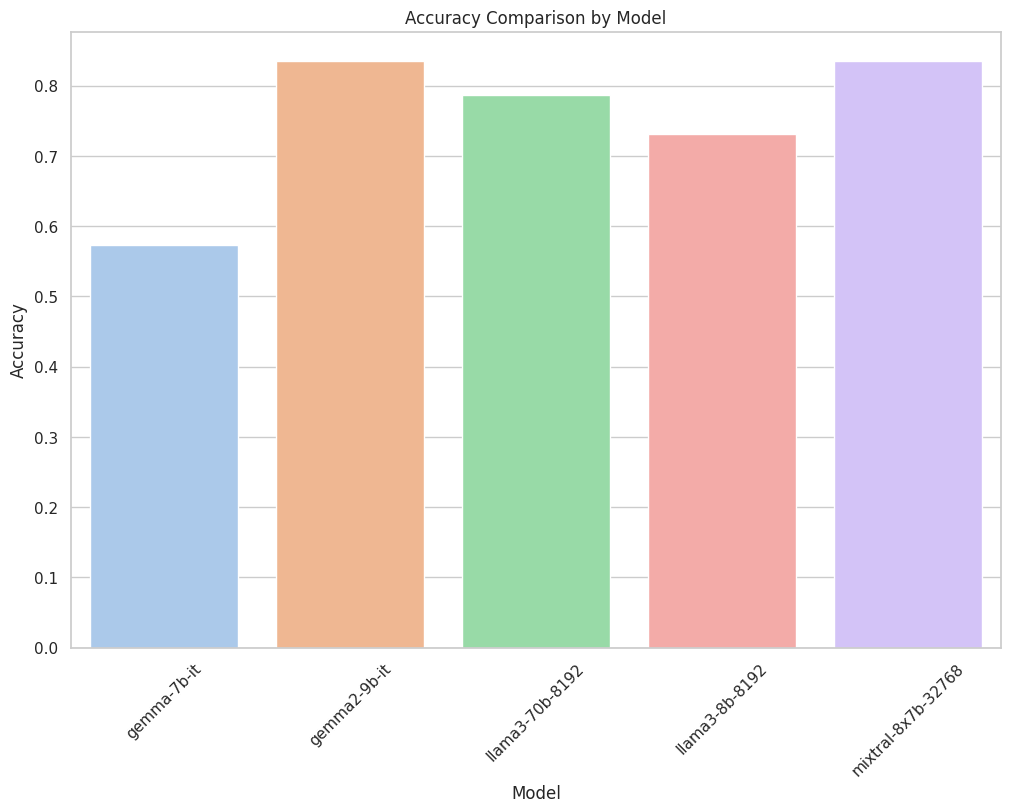

/tmp/ipykernel_3527/572861603.py:61: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=model_color_map, ci=None)
/tmp/ipykernel_3527/572861603.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=model_color_map, ci=None)


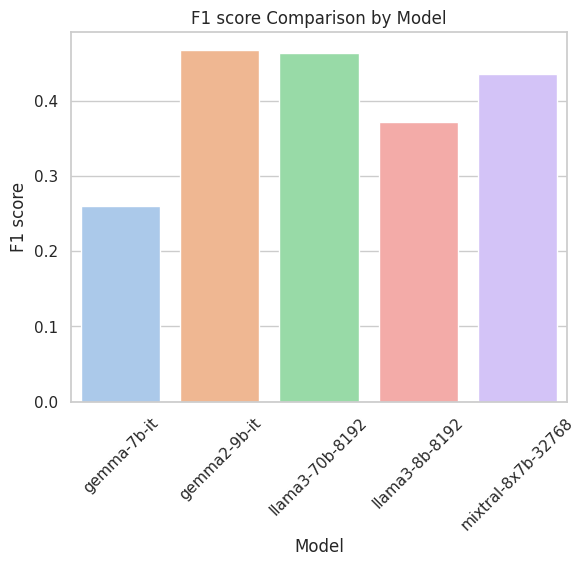

/tmp/ipykernel_3527/572861603.py:61: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=model_color_map, ci=None)
/tmp/ipykernel_3527/572861603.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=model_color_map, ci=None)


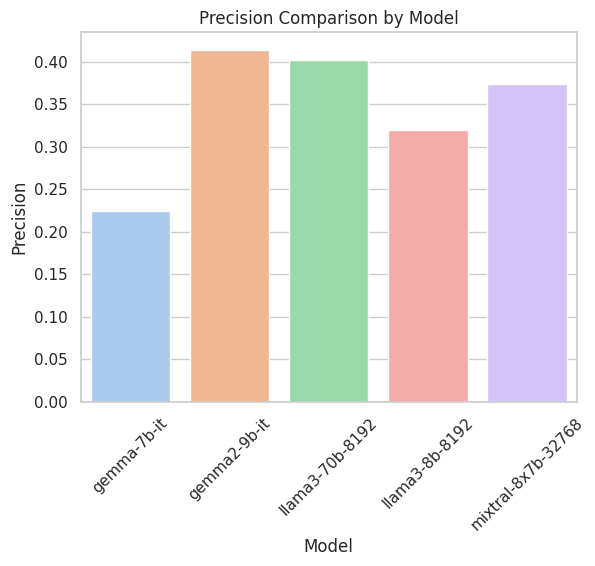

/tmp/ipykernel_3527/572861603.py:61: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=model_color_map, ci=None)
/tmp/ipykernel_3527/572861603.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=model_color_map, ci=None)


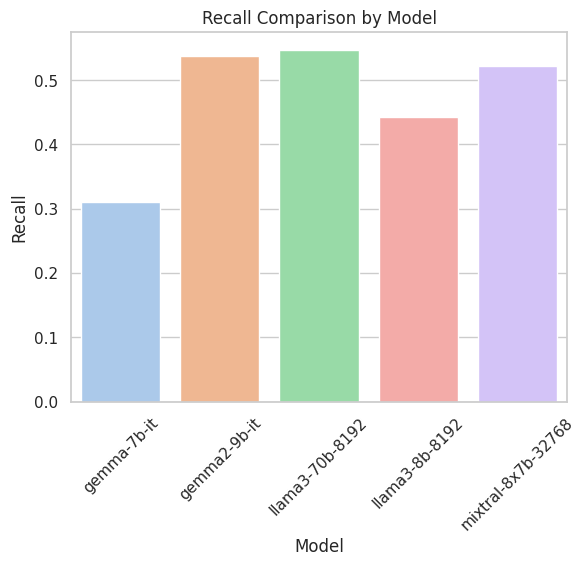

/tmp/ipykernel_3527/572861603.py:61: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=model_color_map, ci=None)
/tmp/ipykernel_3527/572861603.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=model_color_map, ci=None)


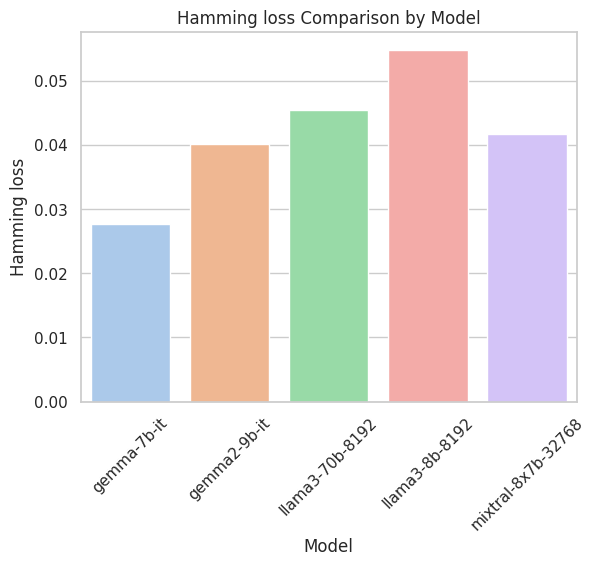

Model: gemma-7b-it
  Accuracy: 57.32%
  F1_score: 26.00%
  Precision: 22.36%
  Recall: 31.07%
  Hamming_loss: 2.77%
Model: gemma2-9b-it
  Accuracy: 83.49%
  F1_score: 46.79%
  Precision: 41.41%
  Recall: 53.78%
  Hamming_loss: 4.02%
Model: llama3-70b-8192
  Accuracy: 78.72%
  F1_score: 46.38%
  Precision: 40.22%
  Recall: 54.77%
  Hamming_loss: 4.54%
Model: llama3-8b-8192
  Accuracy: 73.12%
  F1_score: 37.15%
  Precision: 31.97%
  Recall: 44.33%
  Hamming_loss: 5.49%
Model: mixtral-8x7b-32768
  Accuracy: 83.52%
  F1_score: 43.58%
  Precision: 37.41%
  Recall: 52.20%
  Hamming_loss: 4.17%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, hamming_loss

def calculate_metrics_improved(df):
    def get_true_labels(row):
        if row['topic'] == 'Mixed':
            return set(str(col) for col in df.columns[5:-1] if row[col] == 1)
        else:
            return {str(row['topic'])}
    
    def get_pred_labels(pred_str):
        return set(label.strip() for label in str(pred_str).split(',') if label.strip())

    y_true = df.apply(get_true_labels, axis=1)
    y_pred = df['prediction'].apply(get_pred_labels)

    correct = sum(len(true.intersection(pred)) > 0 for true, pred in zip(y_true, y_pred))
    total = len(df)

    accuracy = correct / total

    # For other metrics, we'll create binary labels for each unique class
    all_labels = sorted(set.union(*y_true, *y_pred))
    
    y_true_bin = [[1 if label in true_set else 0 for label in all_labels] for true_set in y_true]
    y_pred_bin = [[1 if label in pred_set else 0 for label in all_labels] for pred_set in y_pred]

    f1 = f1_score(y_true_bin, y_pred_bin, average='micro')
    precision = precision_score(y_true_bin, y_pred_bin, average='micro', zero_division=0)
    recall = recall_score(y_true_bin, y_pred_bin, average='micro')
    hamming = hamming_loss(y_true_bin, y_pred_bin)

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'hamming_loss': hamming,
    }

# Use the function
metrics = calculate_metrics_improved(clean_small_test_df)

# Group by model and calculate accuracies for each model
model_accuracies = {}
for model_name, group_df in clean_small_test_df.groupby('model'):
    model_accuracies[model_name] = calculate_metrics_improved(group_df)

# Convert the results to a DataFrame for easier plotting
accuracies_df = pd.DataFrame(model_accuracies).T

# Plotting
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Plot each accuracy metric
for metric in accuracies_df.columns:
    sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=model_color_map, ci=None)
    plt.title(f'{metric.replace("_", " ").capitalize()} Comparison by Model')
    plt.xlabel('Model')
    plt.ylabel(metric.replace('_', ' ').capitalize())
    plt.xticks(rotation=45)
    plt.show()

# Print results
for model, metrics in model_accuracies.items():
    print(f"Model: {model}")
    for metric, value in metrics.items():
        print(f"  {metric.capitalize()}: {value:.2%}")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import hamming_loss

def calculate_multi_label_accuracies(df):
    def get_true_labels(row):
        if row['topic'] == 'Mixed':
            return set(str(col) for col in df.columns[5:-1] if row[col] == 1)
        else:
            return {str(row['topic'])}
    
    def get_pred_labels(pred_str):
        return set(label.strip() for label in str(pred_str).split(',') if label.strip())

    y_true = df.apply(get_true_labels, axis=1)
    y_pred = df['prediction'].apply(get_pred_labels)


    total_samples = len(df)
    all_labels = sorted(set.union(*y_true, *y_pred))

    # Exact Match Accuracy
    exact_match = sum(t == p for t, p in zip(y_true, y_pred)) / total_samples

    # Subset Accuracy
    subset_accuracy = sum(t.issubset(p) for t, p in zip(y_true, y_pred)) / total_samples

    # Partial Match Accuracy
    partial_match = sum(len(t.intersection(p)) > 0 for t, p in zip(y_true, y_pred)) / total_samples

    # Hamming Accuracy
    y_true_bin = [[1 if label in true_set else 0 for label in all_labels] for true_set in y_true]
    y_pred_bin = [[1 if label in pred_set else 0 for label in all_labels] for pred_set in y_pred]
    
    hamming_accuracy = 1 - hamming_loss(y_true_bin, y_pred_bin)

    # Label-based Accuracy
    label_accuracies = []
    for label in all_labels:
        true_label = [label in true_set for true_set in y_true]
        pred_label = [label in pred_set for pred_set in y_pred]
        label_accuracies.append(sum(t == p for t, p in zip(true_label, pred_label)) / total_samples)
    label_based_accuracy = np.mean(label_accuracies)

    return {
        'exact_match_accuracy': exact_match,
        'subset_accuracy': subset_accuracy,
        'partial_match_accuracy': partial_match,
        'hamming_accuracy': hamming_accuracy,
        'label_based_accuracy': label_based_accuracy
    }

# Use the function
accuracies = calculate_multi_label_accuracies(clean_small_test_df)

# Print results
for metric, value in accuracies.items():
    print(f"{metric.capitalize()}: {value:.2%}")

Exact_match_accuracy: 2.13%
Subset_accuracy: 25.59%
Partial_match_accuracy: 75.91%
Hamming_accuracy: 98.48%
Label_based_accuracy: 98.48%


/tmp/ipykernel_3527/510135491.py:82: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=model_color_map, ci=None)
/tmp/ipykernel_3527/510135491.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=model_color_map, ci=None)


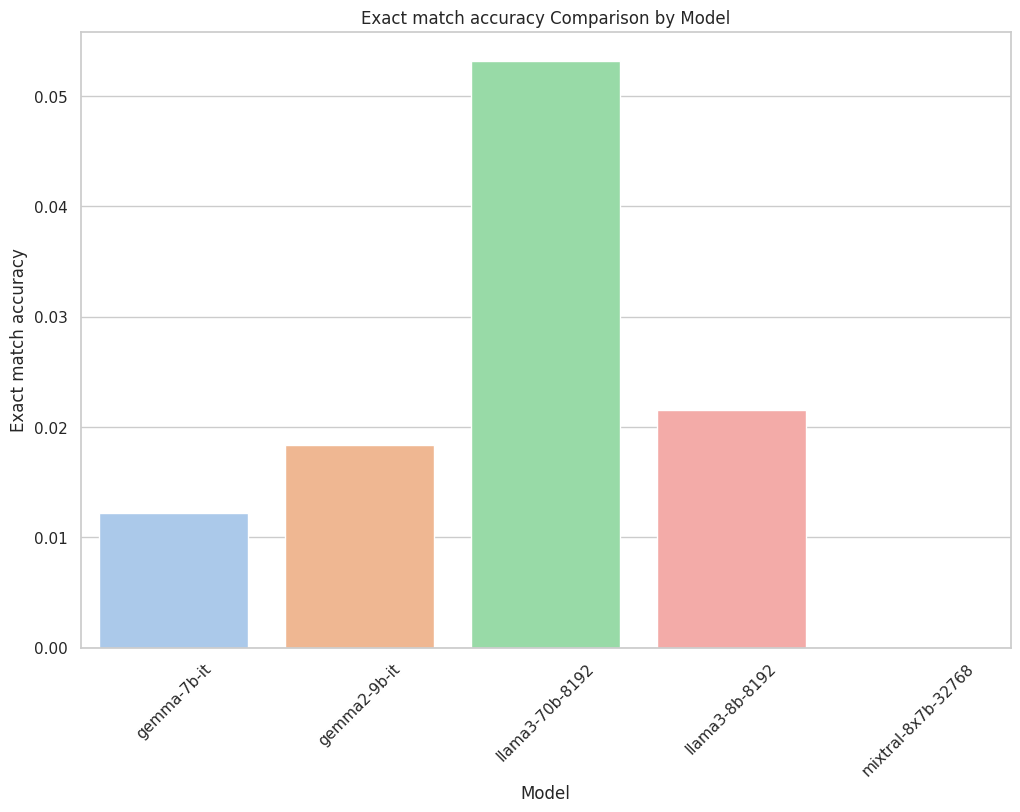

/tmp/ipykernel_3527/510135491.py:82: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=model_color_map, ci=None)
/tmp/ipykernel_3527/510135491.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=model_color_map, ci=None)


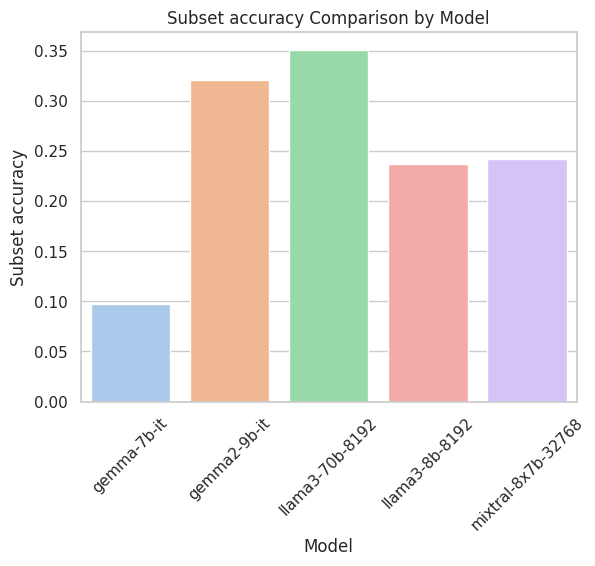

/tmp/ipykernel_3527/510135491.py:82: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=model_color_map, ci=None)
/tmp/ipykernel_3527/510135491.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=model_color_map, ci=None)


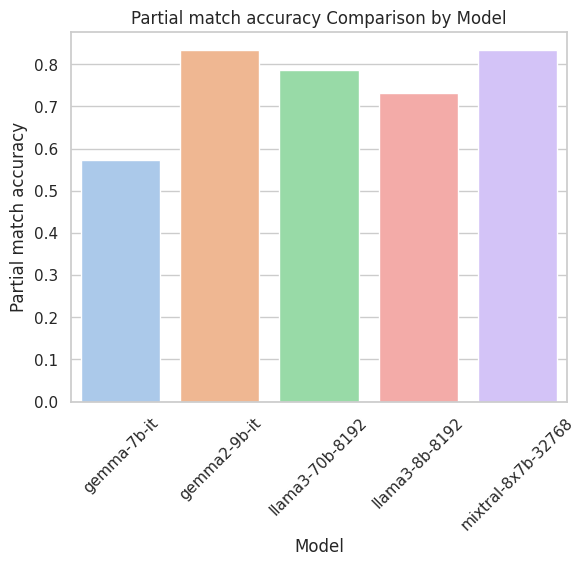

/tmp/ipykernel_3527/510135491.py:82: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=model_color_map, ci=None)
/tmp/ipykernel_3527/510135491.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=model_color_map, ci=None)


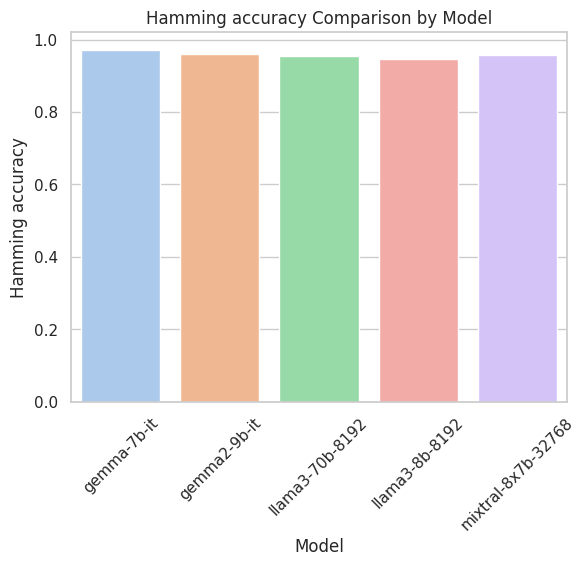

/tmp/ipykernel_3527/510135491.py:82: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=model_color_map, ci=None)
/tmp/ipykernel_3527/510135491.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=model_color_map, ci=None)


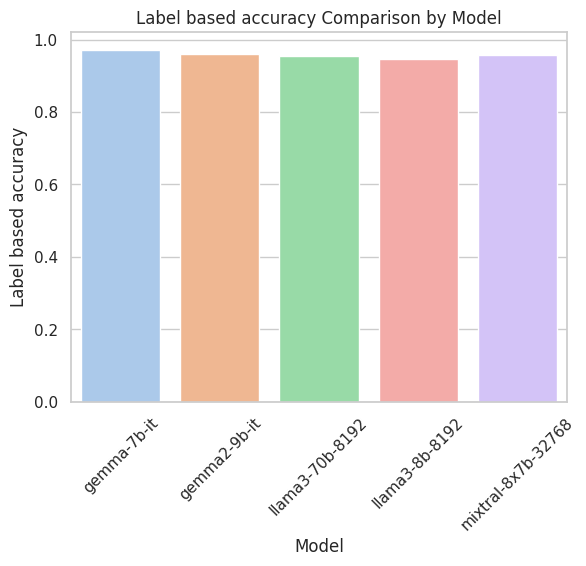

Model: gemma-7b-it
  Exact_match_accuracy: 1.22%
  Subset_accuracy: 9.76%
  Partial_match_accuracy: 57.32%
  Hamming_accuracy: 97.23%
  Label_based_accuracy: 97.23%
Model: gemma2-9b-it
  Exact_match_accuracy: 1.83%
  Subset_accuracy: 32.11%
  Partial_match_accuracy: 83.49%
  Hamming_accuracy: 95.98%
  Label_based_accuracy: 95.98%
Model: llama3-70b-8192
  Exact_match_accuracy: 5.32%
  Subset_accuracy: 35.11%
  Partial_match_accuracy: 78.72%
  Hamming_accuracy: 95.46%
  Label_based_accuracy: 95.46%
Model: llama3-8b-8192
  Exact_match_accuracy: 2.15%
  Subset_accuracy: 23.66%
  Partial_match_accuracy: 73.12%
  Hamming_accuracy: 94.51%
  Label_based_accuracy: 94.51%
Model: mixtral-8x7b-32768
  Exact_match_accuracy: 0.00%
  Subset_accuracy: 24.18%
  Partial_match_accuracy: 83.52%
  Hamming_accuracy: 95.83%
  Label_based_accuracy: 95.83%


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import hamming_loss
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any

def calculate_multi_label_accuracies(df: pd.DataFrame) -> Dict[str, float]:
    """
    Calculate various multi-label accuracies for a given DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing true labels and predictions.

    Returns
    -------
    Dict[str, float]
        A dictionary containing different accuracy metrics.
    """
    def get_true_labels(row: pd.Series) -> set:
        if row['topic'] == 'Mixed':
            return set(str(col) for col in df.columns[5:-1] if row[col] == 1)
        else:
            return {str(row['topic'])}
    
    def get_pred_labels(pred_str: str) -> set:
        return set(label.strip() for label in str(pred_str).split(',') if label.strip())

    y_true = df.apply(get_true_labels, axis=1)
    y_pred = df['prediction'].apply(get_pred_labels)

    total_samples = len(df)
    all_labels = sorted(set.union(*y_true, *y_pred))

    # Exact Match Accuracy
    exact_match = sum(t == p for t, p in zip(y_true, y_pred)) / total_samples

    # Subset Accuracy
    subset_accuracy = sum(t.issubset(p) for t, p in zip(y_true, y_pred)) / total_samples

    # Partial Match Accuracy
    partial_match = sum(len(t.intersection(p)) > 0 for t, p in zip(y_true, y_pred)) / total_samples

    # Hamming Accuracy
    y_true_bin = [[1 if label in true_set else 0 for label in all_labels] for true_set in y_true]
    y_pred_bin = [[1 if label in pred_set else 0 for label in all_labels] for pred_set in y_pred]
    
    hamming_accuracy = 1 - hamming_loss(y_true_bin, y_pred_bin)

    # Label-based Accuracy
    label_accuracies = []
    for label in all_labels:
        true_label = [label in true_set for true_set in y_true]
        pred_label = [label in pred_set for pred_set in y_pred]
        label_accuracies.append(sum(t == p for t, p in zip(true_label, pred_label)) / total_samples)
    label_based_accuracy = np.mean(label_accuracies)

    return {
        'exact_match_accuracy': exact_match,
        'subset_accuracy': subset_accuracy,
        'partial_match_accuracy': partial_match,
        'hamming_accuracy': hamming_accuracy,
        'label_based_accuracy': label_based_accuracy
    }

# Group by model and calculate accuracies for each model
model_accuracies = {}
for model_name, group_df in clean_small_test_df.groupby('model'):
    model_accuracies[model_name] = calculate_multi_label_accuracies(group_df)

# Convert the results to a DataFrame for easier plotting
accuracies_df = pd.DataFrame(model_accuracies).T

# Plotting
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Plot each accuracy metric
for metric in accuracies_df.columns:
    sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=model_color_map, ci=None)
    plt.title(f'{metric.replace("_", " ").capitalize()} Comparison by Model')
    plt.xlabel('Model')
    plt.ylabel(metric.replace('_', ' ').capitalize())
    plt.xticks(rotation=45)
    plt.show()

# Print results
for model, metrics in model_accuracies.items():
    print(f"Model: {model}")
    for metric, value in metrics.items():
        print(f"  {metric.capitalize()}: {value:.2%}")

/tmp/ipykernel_3527/1442101684.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=labels_color_map, ci=None)
/tmp/ipykernel_3527/1442101684.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=labels_color_map, ci=None)


<Figure size 1200x800 with 0 Axes>

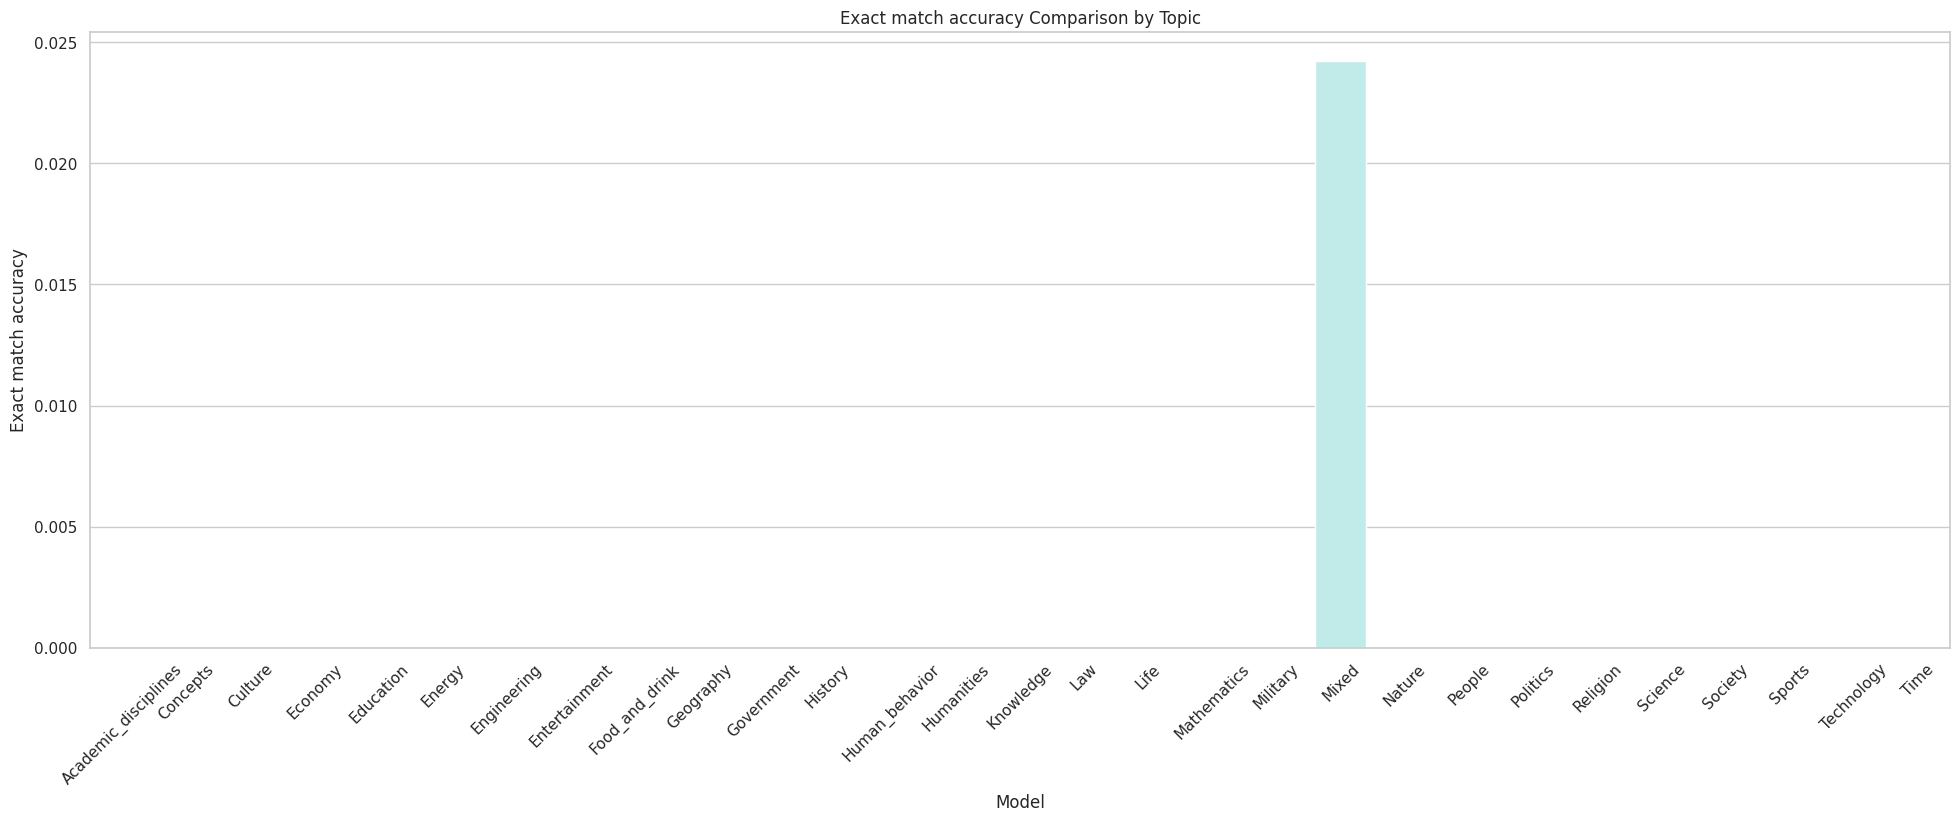

/tmp/ipykernel_3527/1442101684.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=labels_color_map, ci=None)
/tmp/ipykernel_3527/1442101684.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=labels_color_map, ci=None)


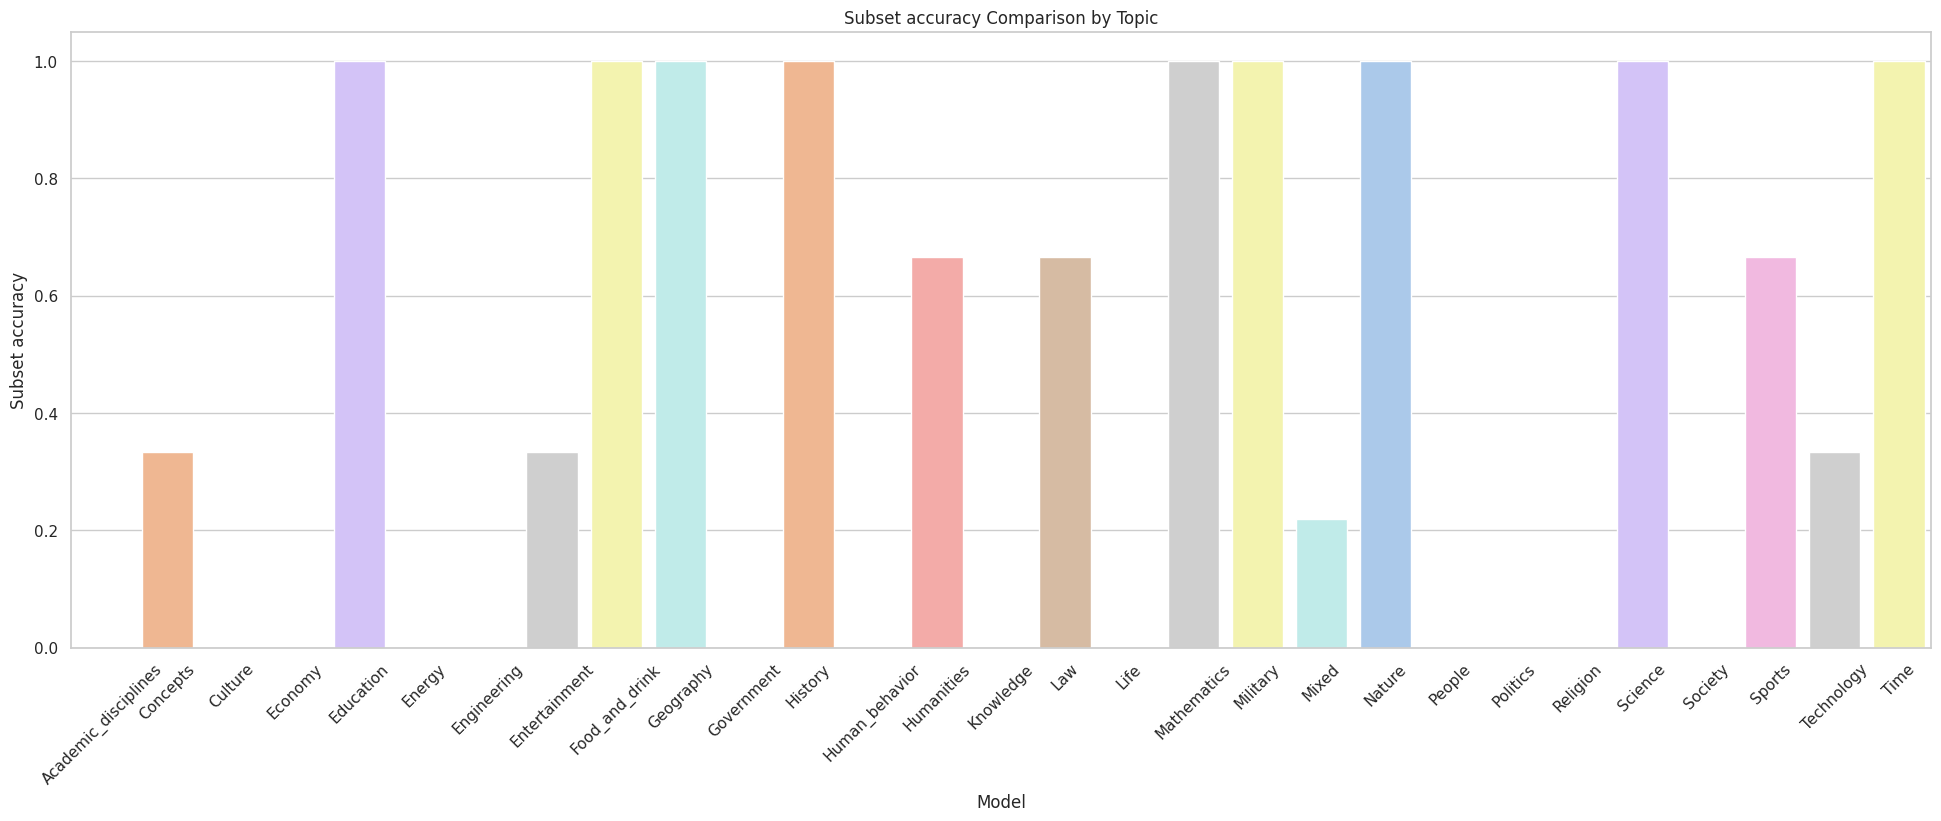

/tmp/ipykernel_3527/1442101684.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=labels_color_map, ci=None)
/tmp/ipykernel_3527/1442101684.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=labels_color_map, ci=None)


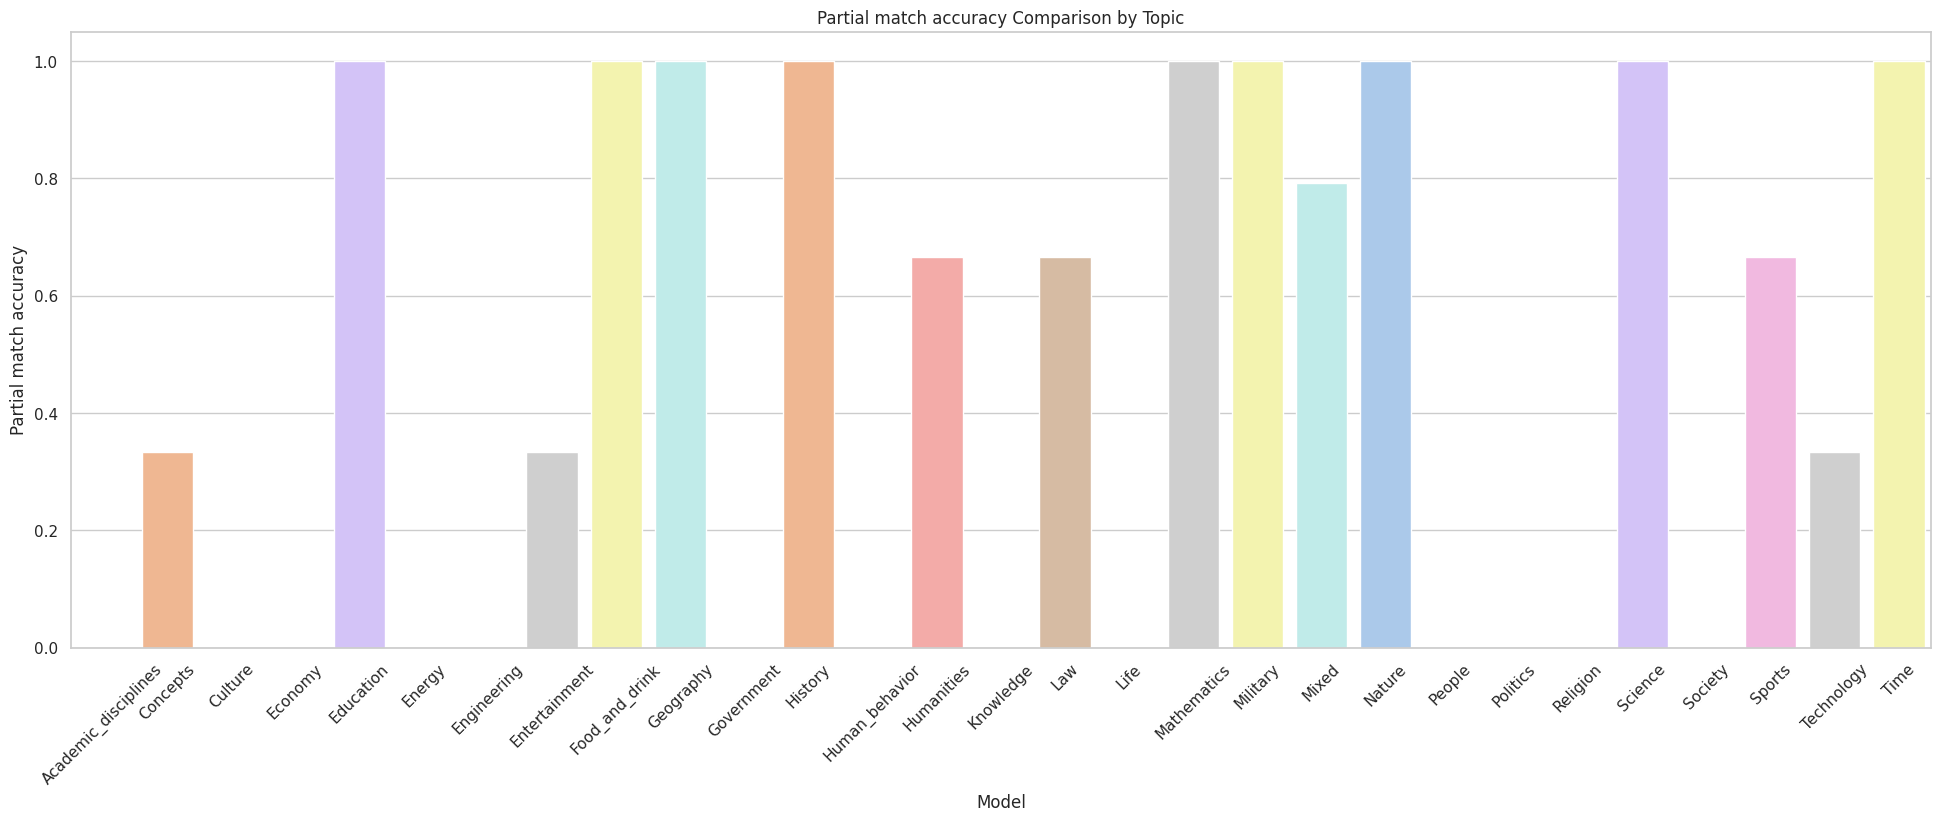

/tmp/ipykernel_3527/1442101684.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=labels_color_map, ci=None)
/tmp/ipykernel_3527/1442101684.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=labels_color_map, ci=None)


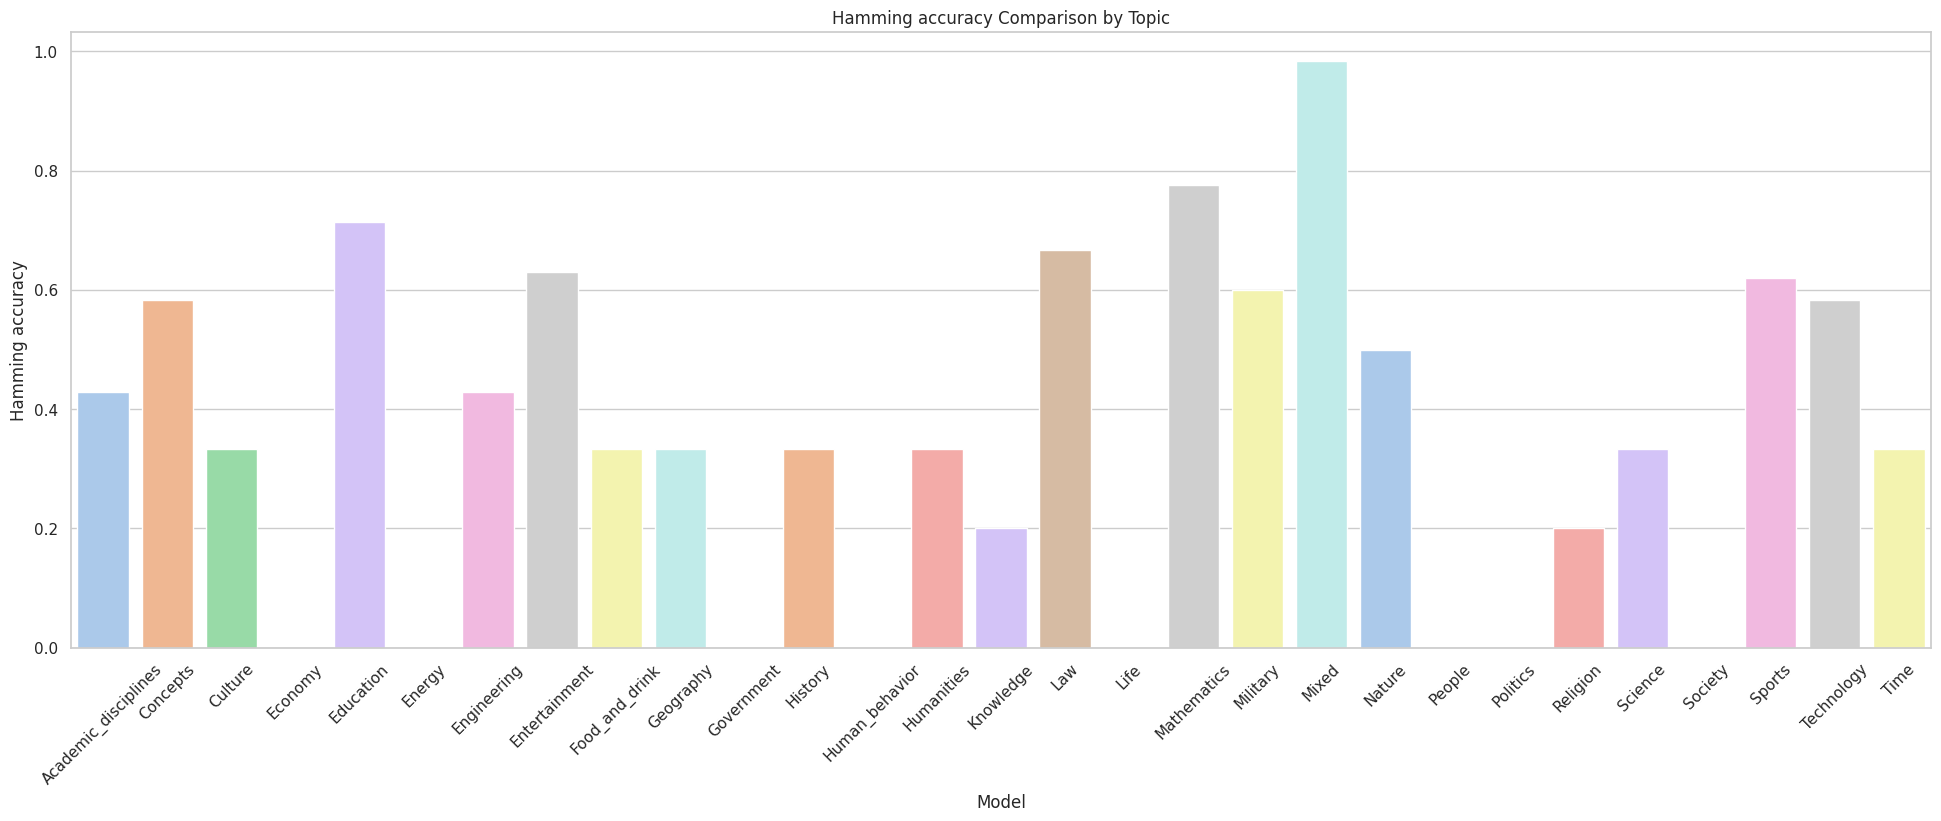

/tmp/ipykernel_3527/1442101684.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=labels_color_map, ci=None)
/tmp/ipykernel_3527/1442101684.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=labels_color_map, ci=None)


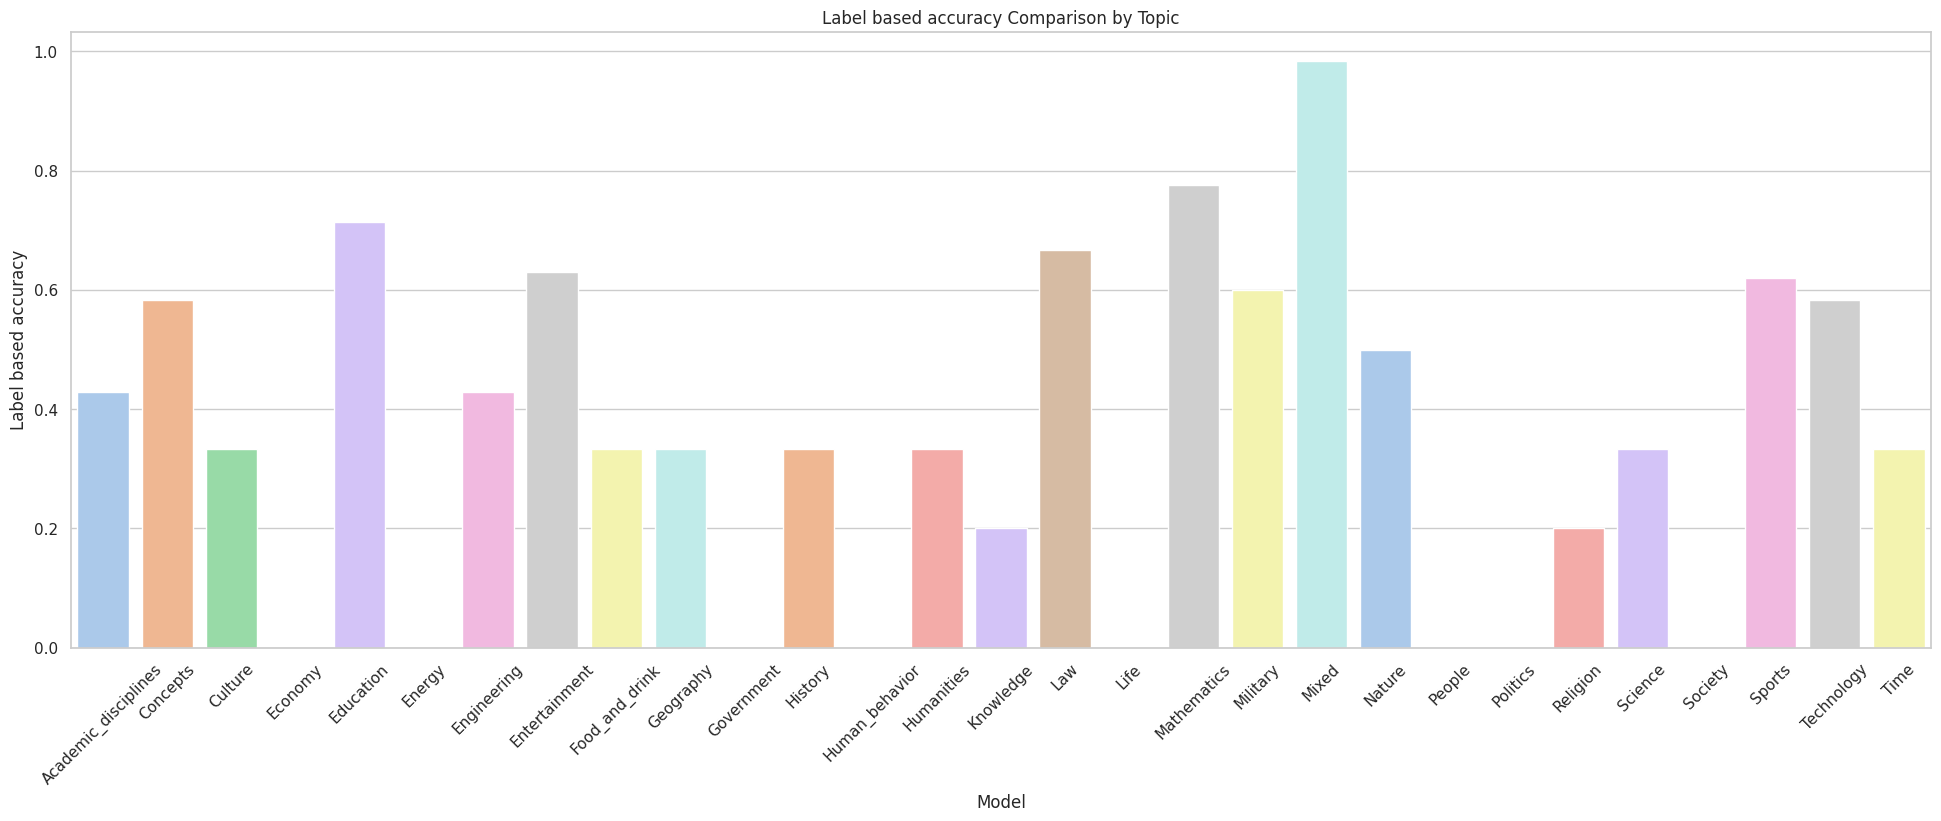

Model: Academic_disciplines
  Exact_match_accuracy: 0.00%
  Subset_accuracy: 0.00%
  Partial_match_accuracy: 0.00%
  Hamming_accuracy: 42.86%
  Label_based_accuracy: 42.86%
Model: Concepts
  Exact_match_accuracy: 0.00%
  Subset_accuracy: 33.33%
  Partial_match_accuracy: 33.33%
  Hamming_accuracy: 58.33%
  Label_based_accuracy: 58.33%
Model: Culture
  Exact_match_accuracy: 0.00%
  Subset_accuracy: 0.00%
  Partial_match_accuracy: 0.00%
  Hamming_accuracy: 33.33%
  Label_based_accuracy: 33.33%
Model: Economy
  Exact_match_accuracy: 0.00%
  Subset_accuracy: 0.00%
  Partial_match_accuracy: 0.00%
  Hamming_accuracy: 0.00%
  Label_based_accuracy: 0.00%
Model: Education
  Exact_match_accuracy: 0.00%
  Subset_accuracy: 100.00%
  Partial_match_accuracy: 100.00%
  Hamming_accuracy: 71.43%
  Label_based_accuracy: 71.43%
Model: Energy
  Exact_match_accuracy: 0.00%
  Subset_accuracy: 0.00%
  Partial_match_accuracy: 0.00%
  Hamming_accuracy: 0.00%
  Label_based_accuracy: 0.00%
Model: Engineering
  Ex

In [ ]:
# Group by model and calculate accuracies for each model
model_accuracies = {}
for model_name, group_df in clean_small_test_df.groupby('topic'):
    model_accuracies[model_name] = calculate_multi_label_accuracies(group_df)

# Convert the results to a DataFrame for easier plotting
accuracies_df = pd.DataFrame(model_accuracies).T

# Plotting
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Assuming 'clean_small_test_df' contains a 'model' column with the model names
labels_names = sorted(clean_small_test_df['topic'].unique())

# Define a color palette for the models
colors = sns.color_palette('pastel', len(labels_names))  # 'husl' is a nice perceptually uniform palette
labels_color_map = dict(zip(labels_names, colors))

# Plot each accuracy metric
for metric in accuracies_df.columns:
    plt.figure(figsize=(24, 8))
    sns.set(style="whitegrid")
    
    sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=labels_color_map, ci=None)
    plt.title(f'{metric.replace("_", " ").capitalize()} Comparison by Topic')
    plt.xlabel('Model')
    plt.ylabel(metric.replace('_', ' ').capitalize())
    plt.xticks(rotation=45)
    plt.show()

# Print results
for model, metrics in model_accuracies.items():
    print(f"Model: {model}")
    for metric, value in metrics.items():
        print(f"  {metric.capitalize()}: {value:.2%}")

/tmp/ipykernel_3527/1290185933.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=labels_color_map, ci=None)
/tmp/ipykernel_3527/1290185933.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=labels_color_map, ci=None)


<Figure size 2400x800 with 0 Axes>

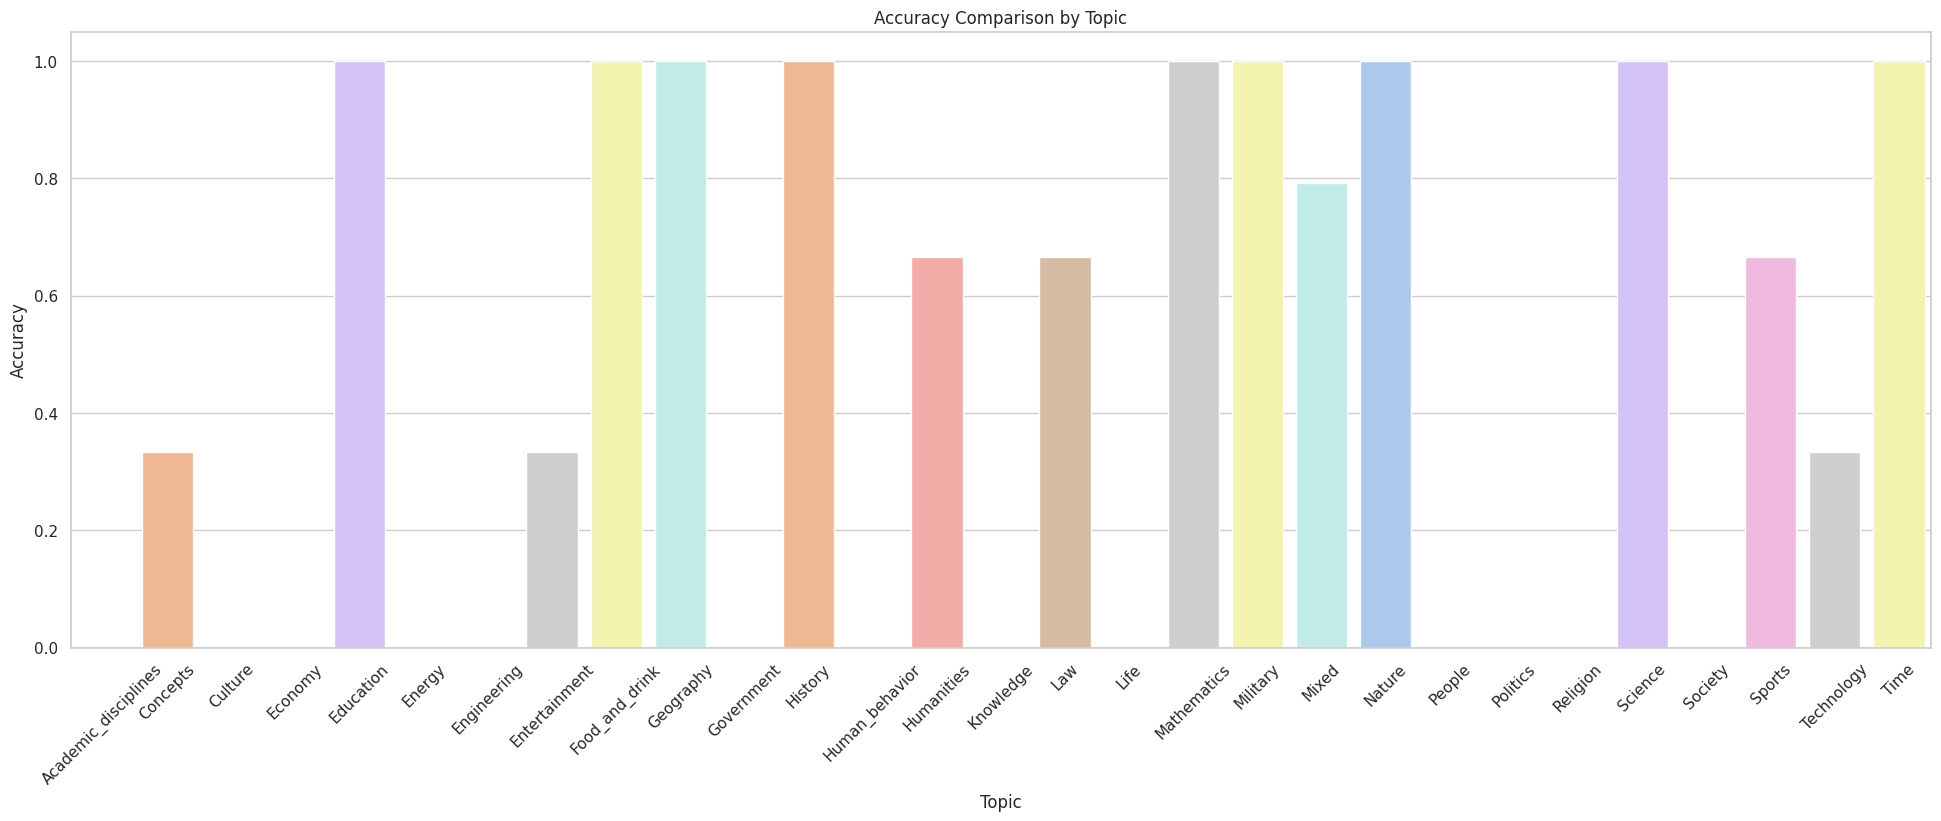

/tmp/ipykernel_3527/1290185933.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=labels_color_map, ci=None)
/tmp/ipykernel_3527/1290185933.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=labels_color_map, ci=None)


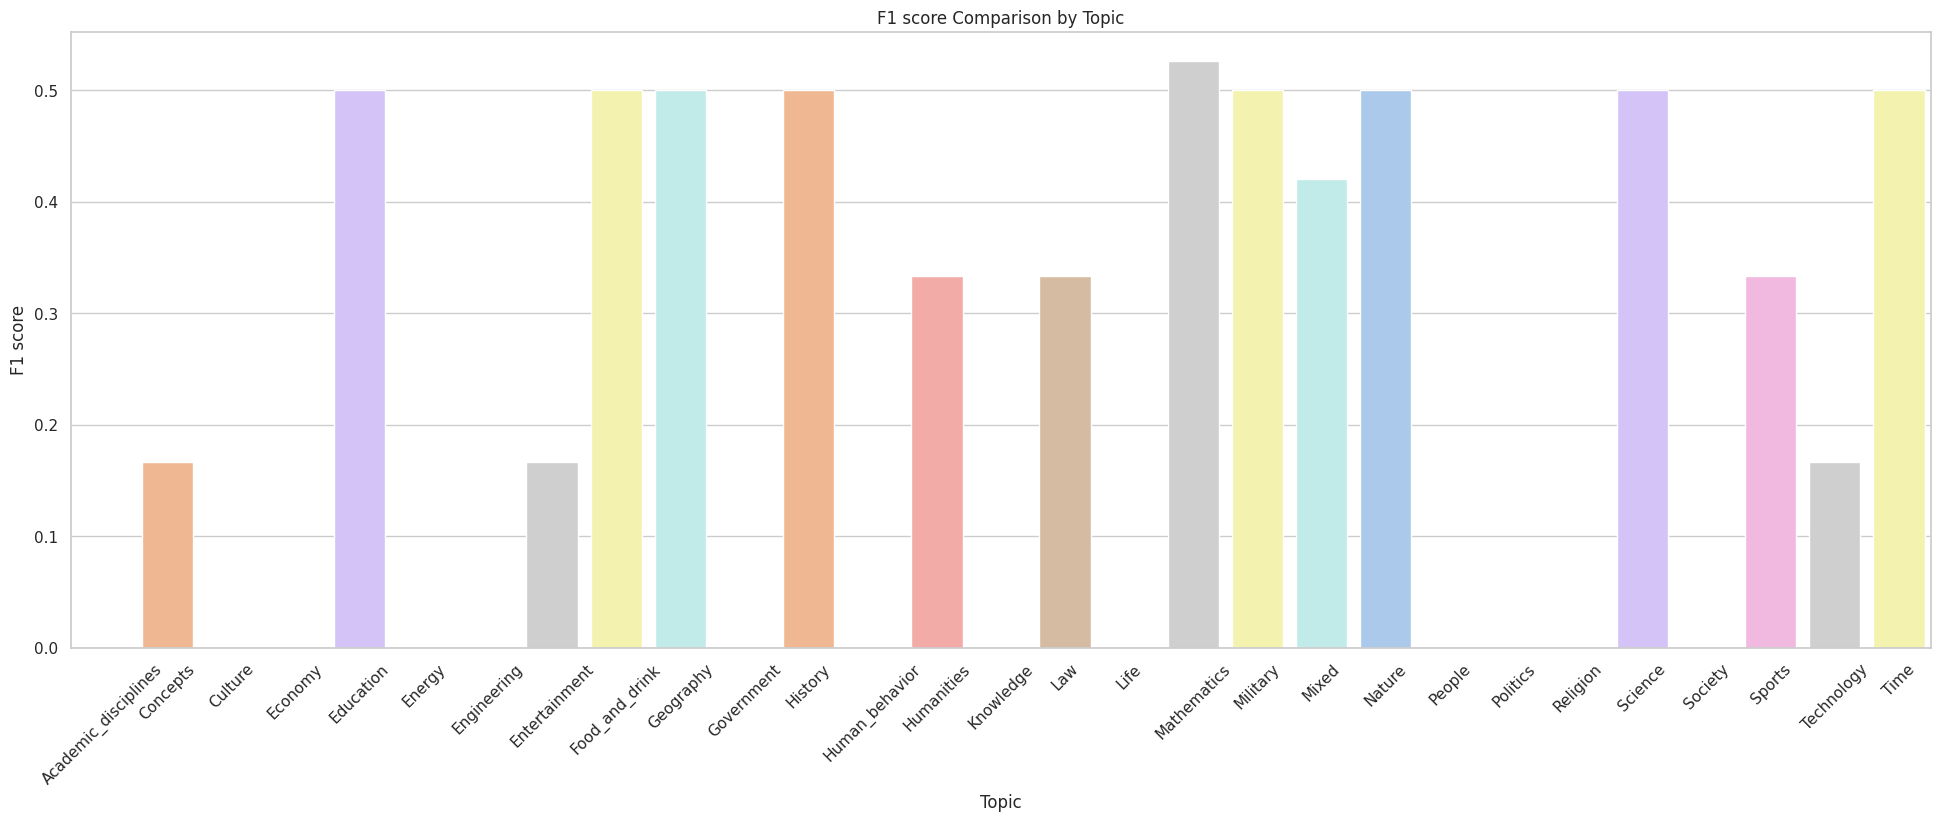

/tmp/ipykernel_3527/1290185933.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=labels_color_map, ci=None)
/tmp/ipykernel_3527/1290185933.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=labels_color_map, ci=None)


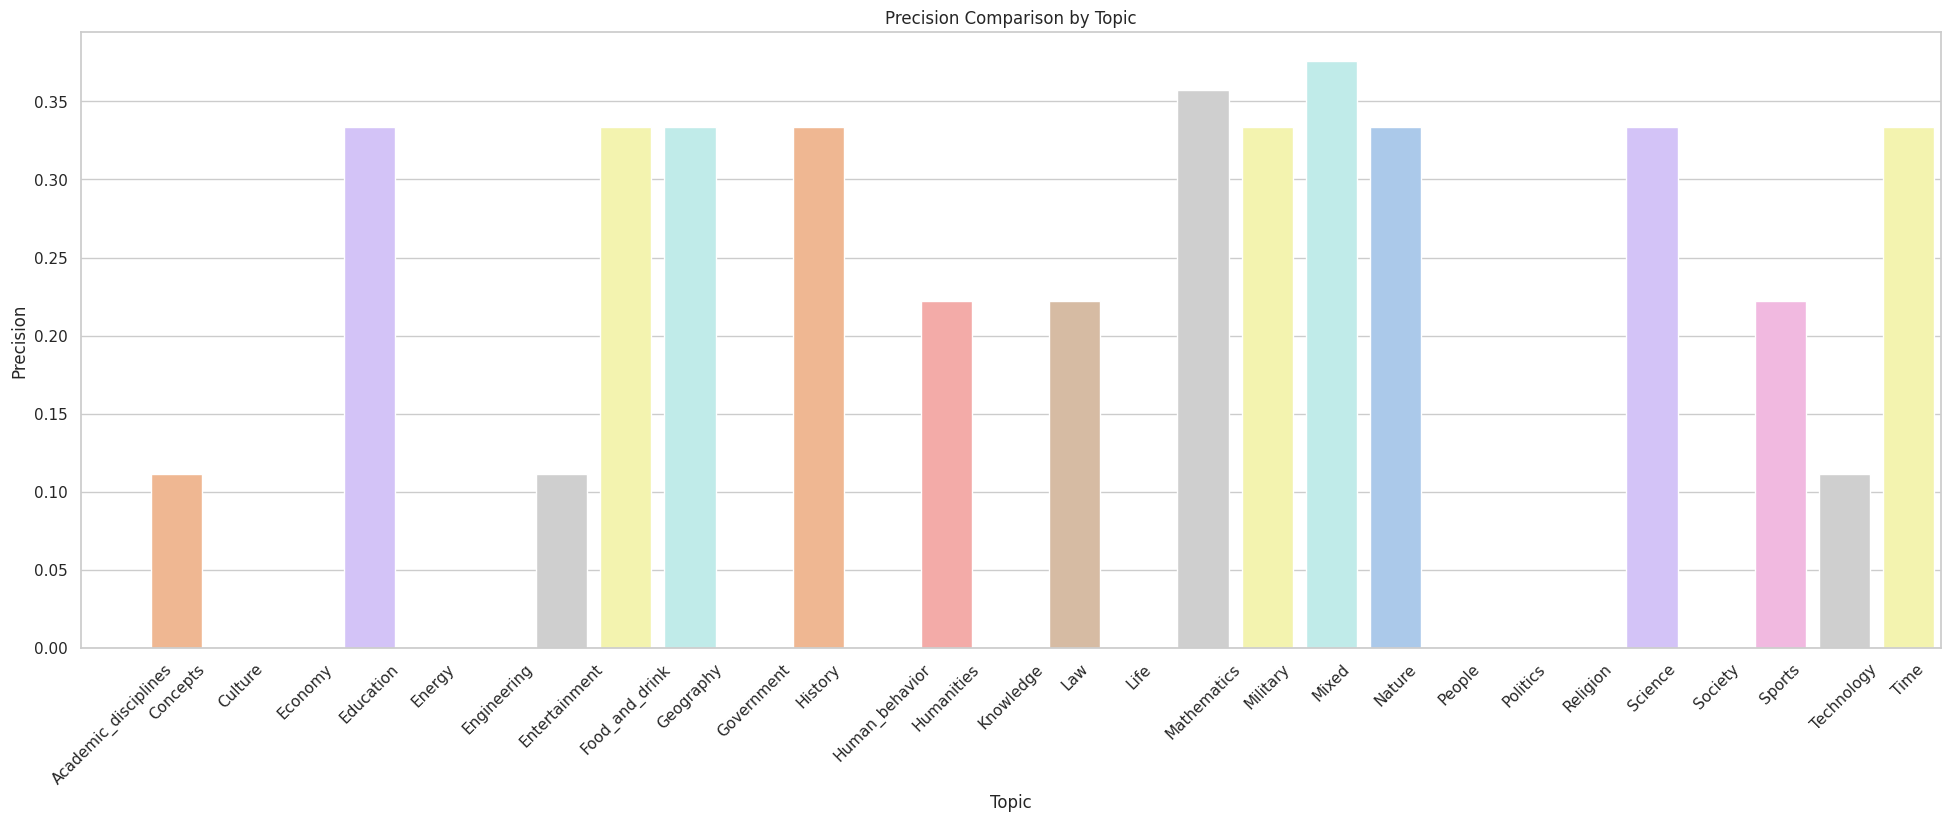

/tmp/ipykernel_3527/1290185933.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=labels_color_map, ci=None)
/tmp/ipykernel_3527/1290185933.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=labels_color_map, ci=None)


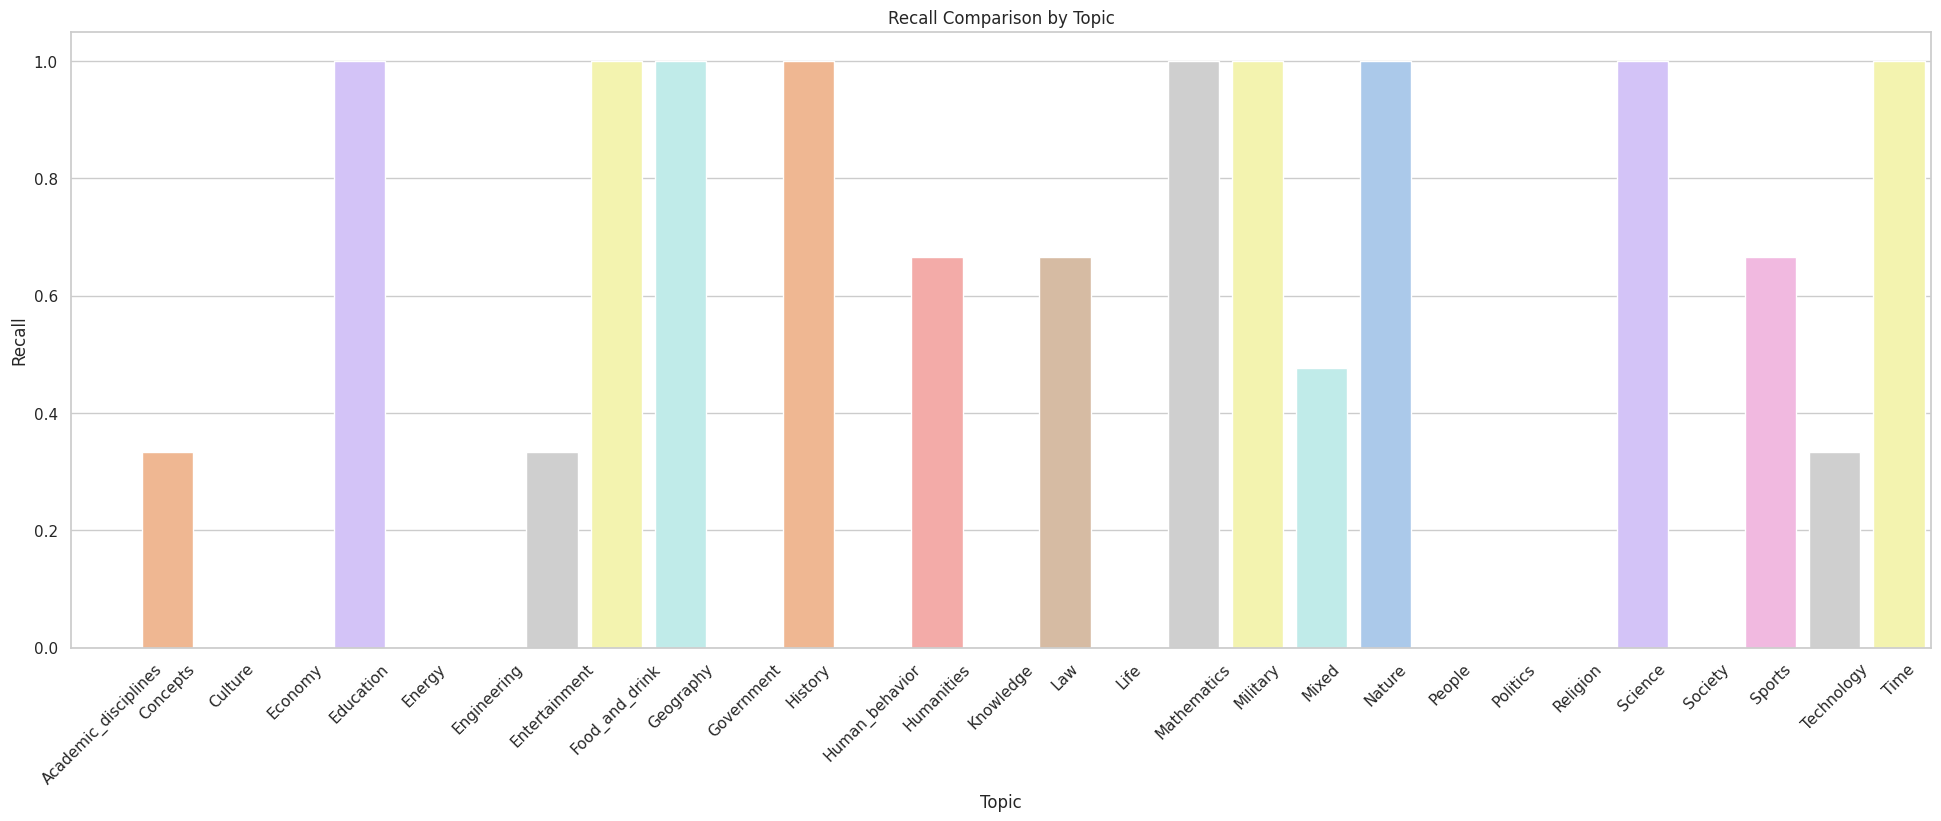

/tmp/ipykernel_3527/1290185933.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=labels_color_map, ci=None)
/tmp/ipykernel_3527/1290185933.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=labels_color_map, ci=None)


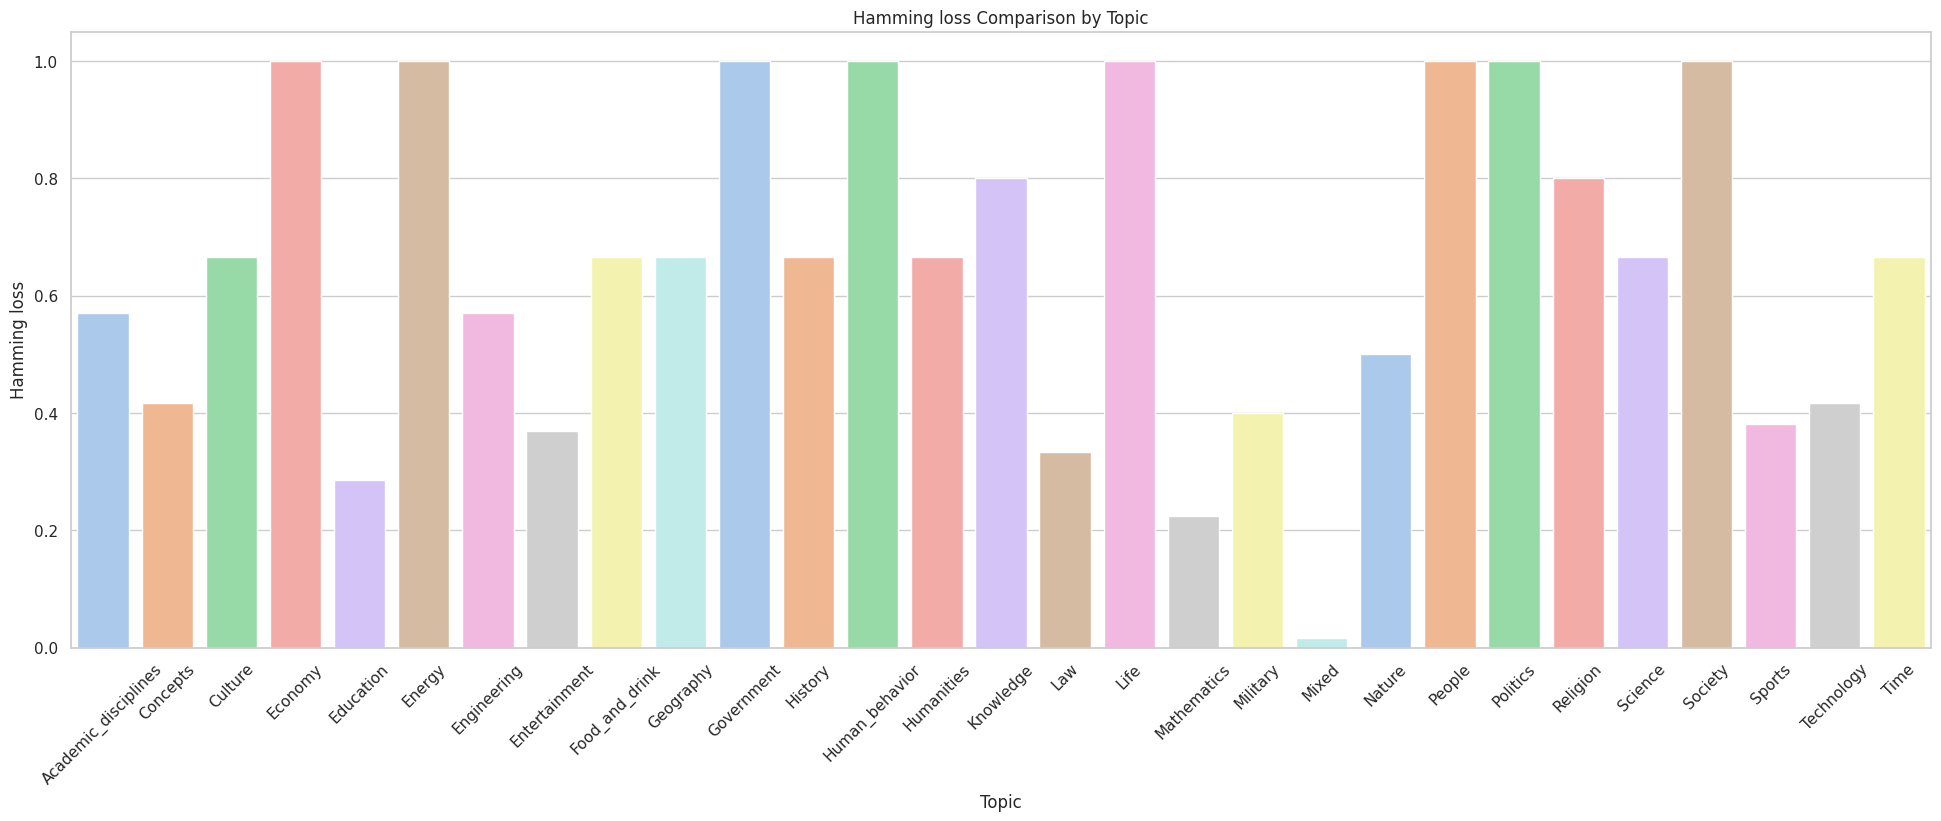

In [ ]:
# Group by model and calculate accuracies for each model
model_accuracies = {}
for model_name, group_df in clean_small_test_df.groupby('topic'):
    model_accuracies[model_name] = calculate_metrics_improved(group_df)

# Convert the results to a DataFrame for easier plotting
accuracies_df = pd.DataFrame(model_accuracies).T

# Plotting
plt.figure(figsize=(24, 8))
sns.set(style="whitegrid")

# Plot each accuracy metric
for metric in accuracies_df.columns:
    plt.figure(figsize=(24, 8))
    sns.set(style="whitegrid")
    
    sns.barplot(x=accuracies_df.index, y=accuracies_df[metric], palette=labels_color_map, ci=None)
    plt.title(f'{metric.replace("_", " ").capitalize()} Comparison by Topic')
    plt.xlabel('Topic')
    plt.ylabel(metric.replace('_', ' ').capitalize())
    plt.xticks(rotation=45)
    plt.show()

# Print results
# for model, metrics in model_accuracies.items():
#     print(f"Model: {model}")
#     for metric, value in metrics.items():
#         print(f"  {metric.capitalize()}: {value:.2%}")

In [ ]:
def get_true_labels(row):
    if row['topic'] == 'Mixed':
        return set(str(col) for col in df.columns[5:-1] if row[col] == 1)
    else:
        return {str(row['topic'])}
    
def get_pred_labels(pred_str):
    return set(label.strip() for label in str(pred_str).split(',') if label.strip())

df_tmp = clean_small_test_df

y_true = df_tmp.apply(get_true_labels, axis=1)
y_pred = df_tmp['prediction'].apply(get_pred_labels)


total_samples = len(df_tmp)
all_labels = sorted(set.union(*y_true, *y_pred))
all_labels

NameError: name 'df' is not defined